# Proyek Pertama : Membuat Model NLP dengan TensorFlow
- Nama: Ahmad Ramadhan
- Email: ahmad.ramadhan@live.jp
- Id Dicoding: dhadhan

## Category & Dataset
- NLP
- Dataset: https://www.kaggle.com/datasets/basilb2s/language-detection

## Install Kaggle

In [1]:
!pip install kaggle

## Import Kaggle Token
Upload Kaggle JSON refer to:
https://www.kaggle.com/discussions/general/156610

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ahrdadan","key":"3871cbeb4058e031a8d5ca32706d2a63"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d basilb2s/language-detection

  0% 0.00/542k [00:00<?, ?B/s]
100% 542k/542k [00:00<00:00, 81.9MB/s]


In [5]:
!unzip language-detection.zip

Archive:  language-detection.zip
  inflating: Language Detection.csv  




---


## NLP Start

In [6]:
# dataframe
import pandas as pd
import numpy as np
import re

# split data
from sklearn.model_selection import train_test_split

# modeling
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# visualisasi loss & acc
import matplotlib.pyplot as plt

In [7]:
# Read Dataset
df = pd.read_csv('Language Detection.csv')
df.head()

,Text,Language
0,"Nature, in the broadest sense, is the natural...",English
1,"""Nature"" can refer to the phenomena of the phy...",English
2,"The study of nature is a large, if not the onl...",English
3,"Although humans are part of nature, human acti...",English
4,[1] The word nature is borrowed from the Old F...,English


In [8]:
# Preprocessing
df = df.dropna(axis=0)
df.drop_duplicates()
df.isna().sum()

Text        0
Language    0
dtype: int64

In [9]:
df = df.rename(columns={'Text': 'text', 'Language':'label'})

In [10]:
name_label = df['label'].unique()
name_label

array(['English', 'Malayalam', 'Hindi', 'Tamil', 'Portugeese', 'French',
       'Dutch', 'Spanish', 'Greek', 'Russian', 'Danish', 'Italian',
       'Turkish', 'Sweedish', 'Arabic', 'German', 'Kannada'], dtype=object)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10337 entries, 0 to 10336
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    10337 non-null  object
 1   label   10337 non-null  object
dtypes: object(2)
memory usage: 161.6+ KB


In [12]:
# Check jumlah item per Category
df['label'].value_counts()

English       1385
French        1014
Spanish        819
Portugeese     739
Italian        698
Russian        692
Sweedish       676
Malayalam      594
Dutch          546
Arabic         536
Turkish        474
German         470
Tamil          469
Danish         428
Kannada        369
Greek          365
Hindi           63
Name: label, dtype: int64

In [13]:
# # Seleksi column label tertentu
selected_labels = ['English', 'French','Spanish','Arabic']
df = df[df['label'].isin(selected_labels)]

In [14]:
# Convert to one-hot encoding
label_pd = pd.get_dummies(df.label)
new_df = pd.concat([df, label_pd], axis=1)
new_df = new_df.drop(columns='label')
new_df.head()

,text,Arabic,English,French,Spanish
0,"Nature, in the broadest sense, is the natural...",0,1,0,0
1,"""Nature"" can refer to the phenomena of the phy...",0,1,0,0
2,"The study of nature is a large, if not the onl...",0,1,0,0
3,"Although humans are part of nature, human acti...",0,1,0,0
4,[1] The word nature is borrowed from the Old F...,0,1,0,0


In [25]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3754 entries, 0 to 9497
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     3754 non-null   object
 1   Arabic   3754 non-null   uint8 
 2   English  3754 non-null   uint8 
 3   French   3754 non-null   uint8 
 4   Spanish  3754 non-null   uint8 
dtypes: object(1), uint8(4)
memory usage: 73.3+ KB


In [15]:
# transform column to array
desc = new_df['text'].values

# Get labels
# labels = name_sentiment.tolist()
label = new_df[selected_labels].values
# label = new_df[name_label].values

In [16]:
# Split Dataset to train (80%) and validation set (20%)
desc_train, desc_test, label_train, label_test = train_test_split(desc, label, test_size=0.2)

In [17]:
#data tokenizing
tokenizer = Tokenizer(num_words=5_000, oov_token='<oov>')
tokenizer.fit_on_texts(desc_train)
tokenizer.fit_on_texts(desc_test)

#data sequencing
train_sequence = tokenizer.texts_to_sequences(desc_train)
test_sequence = tokenizer.texts_to_sequences(desc_test)

#data padding
train_padded = pad_sequences(train_sequence)
test_padded = pad_sequences(test_sequence)

In [18]:
print(train_padded.shape)
print(label_train.shape)
print(test_padded.shape)
print(label_test.shape)

(3003, 150)
(3003, 4)
(751, 144)
(751, 4)


In [19]:
# Modelling
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=7_500, output_dim=64),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(label_test.shape[1], activation='softmax'),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 64)          480000    
                                                                 
 lstm (LSTM)                 (None, 128)               98816     
                                                                 
 dense (Dense)               (None, 128)               16512     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 2

In [20]:
# compile model
# optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [21]:
# add callbacks for desired acc
class stop_callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.94 and logs.get('val_accuracy')>0.94):
      print("\nacc telah dicapai > 94%!")
      self.model.stop_training = True
callbacks = stop_callback()

In [22]:
# train model
num_epochs = 500
history = model.fit(train_padded, label_train,
                    epochs=num_epochs,
                    validation_data=(test_padded, label_test),
                    verbose=1,
                    callbacks=[callbacks])

Epoch 1/500
94/94 [==============================] - 39s 303ms/step - loss: 0.9967 - accuracy: 0.5298 - val_loss: 0.6001 - val_accuracy: 0.7164
Epoch 2/500
94/94 [==============================] - 29s 304ms/step - loss: 0.2463 - accuracy: 0.9118 - val_loss: 0.0509 - val_accuracy: 0.9840
Epoch 3/500
94/94 [==============================] - ETA: 0s - loss: 0.0937 - accuracy: 0.9700
acc telah dicapai > 94%!
94/94 [==============================] - 32s 340ms/step - loss: 0.0937 - accuracy: 0.9700 - val_loss: 0.0585 - val_accuracy: 0.9814


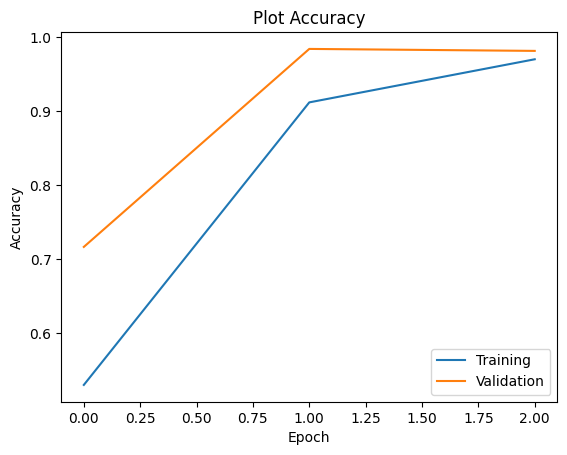

In [23]:
#plot accuracy
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Plot Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

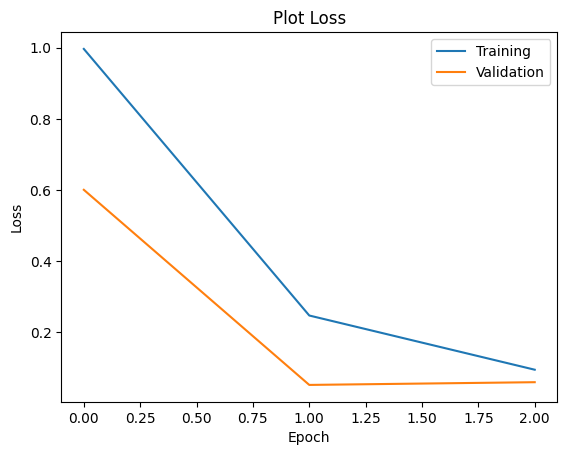

In [24]:
#plot loss
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Plot Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

# Result
Dengan NLP pada deteksi bahasa dari bahasa berikut ini:
- English
- French
- Spanish
- Arabic

Akurasi dan Validasi akurasi yang didapatkan adalah **94%** dengan jumlah datasets 3754